# Explaining models with SHAP

By: Ashwin Nalwade

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. SHAP values interpret the impact of a particular value for a given feature on the prediction, relative to a baseline value of that feature.

You can find the original paper about the SHAP package [here](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf).

SHAP values break down a prediction to show the impact of each feature. Where could you use this?

* A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
* A healthcare provider wants to identify what factors are driving a patient's risk of some disease so they can directly address those risk factors with targeted health interventions (Source: [Kaggle](https://www.kaggle.com/dansbecker/shap-values))



We'll be explaining a sentiment analysis model using SHAP.


In [ ]:
# Required installations
!pip install shap==0.39.0

     |████████████████████████████████| 358kB 4.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491636 sha256=0cef077b274bd60fa3cc3a14b2a1248ff69832f7cf5f4caf51d3fa8b4f3ea19d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
# Import the required modules
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()

## Step 1: Load the IMDB dataset and extract features

The dataset we use is the classic IMDB dataset from [this paper](https://www.aclweb.org/anthology/P11-1015/). It consists of movie reviews, and our task is to predict whether the review is positive or negative. 

In [ ]:
# Load the data
corpus, y = shap.datasets.imdb()

# Take a look at the first example and its corresponding class (True if review is positive)
print('Class:', y[0])
corpus[0]

Class: False


"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

Note that this data is just text. We must preprocess and extract numerical features from the data before feeding it into a classification model. 

In [ ]:
# Split into train and test sets
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

The most intuitive way to transform text into numbers would be to simply count how many times each word occurs in each text. We could represent each document as a vector of word counts, where each element of the vector corresponds to one word in our vocabulary.

For example, consider a corpus of the following documents:
- "The rat ate the pizza."
- "The pizza is delicious."
- "The cats are fluffy."

We have 9 words in the vocabulary: ['ate', 'are', 'cats', 'delicious', 'fluffy', 'is', 'pizza', 'rat', 'the']. We could represent the first document as [1, 0, 0, 0, 0, 0, 1, 1, 2]. 

However, this method has some shortcomings. 

Instead, we're going to use the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn. TF-IDF stands for "term frequency - inverse document frequency." In its simplest form, for each word (term) $i$ in each document $j$, we calculate the TF-DF value $w_{i,j}$ as:

<img src="https://miro.medium.com/max/638/1*Uucq42G4ntPGJKzI84b3aA.png" />

We represent each document as a vector of the TF-IDF values for each word. Using the example above, the first document would be represented as [0.47, 0, 0, 0, 0, 0, 0.17, 0.47, 0].

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Here, the TfidfVectorizor will make this transformation for us. 

In [ ]:
# Fit vectorizer on training data, then transform both the training and test data
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

## Step 2: Fit a logistic regression model on the data

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Evaluate our classifier's performance
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

0.8476

## Step 3: Explain the model using SHAP

We need to create an **explainer** object in SHAP. The type of SHAP explainer we use will be determined by the sort of model that we trained. Because we trained logistic regression model, which is from sklearn.linear_model, we'll want to use a LinearExplainer. See other options [here](https://shap.readthedocs.io/en/latest/#). 

In [ ]:
# Initialize the explainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


### Summary Plot

We can use summary_plot to summarize the most important features. **What are we looking at in this graph?**
- Each dot is an example in the test set
- The color of each dot tells us about the magnitude of the feature -- that is, the magnitude of the TF-IDF value for that word in that document (low to high)
- The SHAP value tells us the contribution of that feature to each prediction

Based on this information, 
- What order are these words in? What determines which words we're seeing in this visualization?
- Why are the dots for the token "and" so tightly clustered?
The token “great” has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

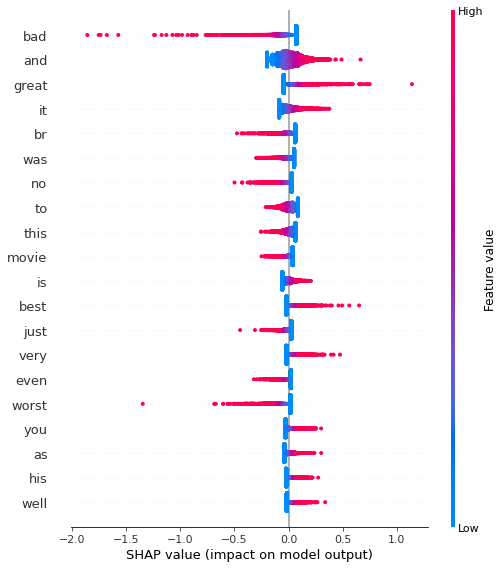

In [ ]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

### Dependence Plots

Dependence plots let us zoom in on a single feature and see how its 1) importance and 2) relationship to the outcome vary across its range.


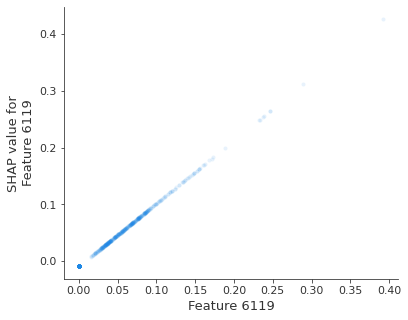

In [ ]:
shap.dependence_plot(vectorizer.get_feature_names().index("fun"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

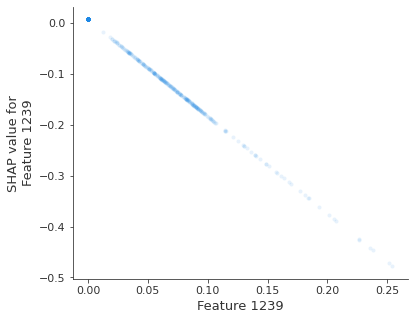

In [ ]:
shap.dependence_plot(vectorizer.get_feature_names().index("awful"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

We can also color the plot by the relationship between two features. For example, we might expect the word "enjoyable" to have a lower SHAP value in texts where we also see the word "not"...

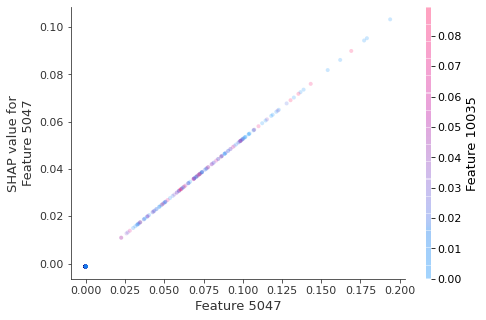

In [ ]:
shap.dependence_plot(vectorizer.get_feature_names().index("enjoyable"), shap_values, X_test_array, alpha=0.2, 
                     interaction_index=vectorizer.get_feature_names().index("not"))

...but this turns out not to be the case because we're using a linear model.

These plots aren't super useful for this particular application, but they *are* important for cases where we suspect a nonlinear relationship between a feature and the outcome. See the results for age in the adult dataset [here](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html).

### Prediction Decomposition

Next, let's look at the explanation for a single review. Here, we decompose a prediction with the following equation:

> sum(SHAP values for all features) = pred_for_review - pred_for_baseline_values

The SHAP values of all features sum up to explain why the prediction was different from the baseline.

In [ ]:
shap.initjs()
idx = 7
print("Positive" if y_test[idx] else "Negative", "Review:")
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Negative Review:
this one of the best celebrity's reality shows a ever saw. we can see the concerts we can see the life of Britney, i love the five episodes. i was always being surprised by Britney and the subjects of the show i think that some people don't watch the show at all we can how a great person she his. she his really funny really gentle and she loves her fans and we can see how she loves her work. i just don't give a 10 because of k-fed he his a real jerk he doesn't seem to like Britney at all. I they make a second season of this great show because it shows at some people how Britney really is. Go Britney your the best and you will never leave our hearts.



We predicted 1.29, whereas the base_value is -0.1842. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. In this example, the biggest impacts come from the features "great" and "best" which are strongly positive.

Next, let's identify the features that contribute to the positive and negative classification of a document:

In [ ]:
# Checking the words that contribute to the positive and negative classification of document 7
idx = 7
vals = shap_values[idx,:]
positive_sentiment_weight = defaultdict(float)
negative_sentiment_weight = defaultdict(float)
feats = vectorizer.get_feature_names()

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_sentiment_weight[feat_i] += val_i
  elif val_i < 0:
    negative_sentiment_weight[feat_i] += val_i

In [ ]:
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]

[('great', 0.2100459961080427),
 ('best', 0.14733915265571612),
 ('shows', 0.07878672524123642),
 ('see', 0.07518528701165034),
 ('love', 0.07146021651095054),
 ('bad', 0.0705152369701555),
 ('his', 0.06706719452400711),
 ('show', 0.06671278441916051),
 ('to', 0.06626035154595687),
 ('br', 0.05995466873609617)]

In [ ]:
list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]

[('it', -0.061794022077312896),
 ('don', -0.059086864572423896),
 ('at', -0.04174696089977672),
 ('is', -0.04167638107915189),
 ('and', -0.04078398715505528),
 ('as', -0.03937013217491601),
 ('in', -0.03805699621584063),
 ('make', -0.0332632104085989),
 ('doesn', -0.027752118851277558),
 ('because', -0.02331981041326142)]

**Another review:**

In [ ]:
# Your code here
list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[10:20]

[('always', 0.04501981544252323),
 ('episodes', 0.03728506719812271),
 ('we', 0.03678854968576229),
 ('movie', 0.036758506639278446),
 ('life', 0.035884570157271846),
 ('season', 0.035865311872106564),
 ('will', 0.03554263483420279),
 ('surprised', 0.0323716054851497),
 ('have', 0.02993005589929202),
 ('she', 0.02918484952711112)]

In [ ]:
shap.initjs()
idx = 8
print("Positive" if y_test[idx] else "Negative", "Review:")
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
I have seen the movie at the Viennale a few years ago, where the audiences liked it. I liked it as well, Summer Phoenix performance still haunts me, that´s why I decided to write a comment.<br /><br />The story unfolds in London around 1900, where a jewish girl decides to become an actress. She tries desperately to become one, but it isn´t before a man treats her badly that she realizes on stage, that she has talent and that she connects with the audience and emerges as a stronger human being.<br /><br />There were certain reviews, were her performance was smashed, they accused her of being dull, not able to bring life to her character. I think that´s her strong point, that´s exactly what Esther Kahn should be and Phoenix makes a brave decision to make her Esther a rather boring girl. So her transformation at the end is more powerful than it could have been otherwise. <br /><br />The cinematography is great, the images of London around the turn of the century are very 